# Autoencoder + Transformer Hybrid Model with SHAP Analysis

In [1]:
# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Data Loading

In [2]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

## Step 2: Data Preprocessing

In [3]:
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Step 3: Define Autoencoder + Transformer Hybrid Model

In [4]:
def build_combined_model(input_dim):
    # Autoencoder Encoder
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    encoded = layers.Dense(32, activation="relu")(x)  # Latent space

    # Transformer
    x = tf.expand_dims(encoded, axis=1)  # Add sequence dimension
    x = layers.Dense(32, activation="relu")(x)
    for _ in range(2):
        x1 = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(32, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification

    # Combine Autoencoder and Transformer
    combined_model = keras.Model(inputs, outputs, name="autoencoder_transformer")
    return combined_model


In [5]:
# Build and compile the combined model
combined_model = build_combined_model(input_dim=x_train.shape[1])
combined_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the combined model
history = combined_model.fit(x_train, y_train, epochs=40, batch_size=64, validation_data=(x_val, y_val))


Epoch 1/40
1575/1575 [==============================] - 43s 24ms/step - loss: 0.0437 - accuracy: 0.9843 - val_loss: 0.0280 - val_accuracy: 0.9905
Epoch 2/40
1575/1575 [==============================] - 40s 25ms/step - loss: 0.0303 - accuracy: 0.9894 - val_loss: 0.0271 - val_accuracy: 0.9911
Epoch 3/40
1575/1575 [==============================] - 39s 25ms/step - loss: 0.0247 - accuracy: 0.9911 - val_loss: 0.0299 - val_accuracy: 0.9913
Epoch 4/40
1575/1575 [==============================] - 41s 26ms/step - loss: 0.0225 - accuracy: 0.9917 - val_loss: 0.0209 - val_accuracy: 0.9921
Epoch 5/40
1575/1575 [==============================] - 40s 26ms/step - loss: 0.0202 - accuracy: 0.9928 - val_loss: 0.0224 - val_accuracy: 0.9923
Epoch 6/40
1575/1575 [==============================] - 40s 26ms/step - loss: 0.0207 - accuracy: 0.9932 - val_loss: 0.0151 - val_accuracy: 0.9948
Epoch 7/40
1575/1575 [==============================] - 42s 26ms/step - loss: 0.0182 - accuracy: 0.9935 - val_loss: 0.0153 -

## Step 4: Evaluate the Model

In [6]:
# Evaluate on test set
test_loss, test_accuracy = combined_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

y_pred = (combined_model.predict(X_test) > 0.5).astype("int32")
y_pred_proba = combined_model.predict(X_test).ravel()


705/705 [==============================] - 6s 9ms/step - loss: 1.7654 - accuracy: 0.7906
Test Loss: 1.7653834819793701, Test Accuracy: 0.7906316518783569
705/705 [==============================] - 6s 9ms/step


## Step 5: Visualizations

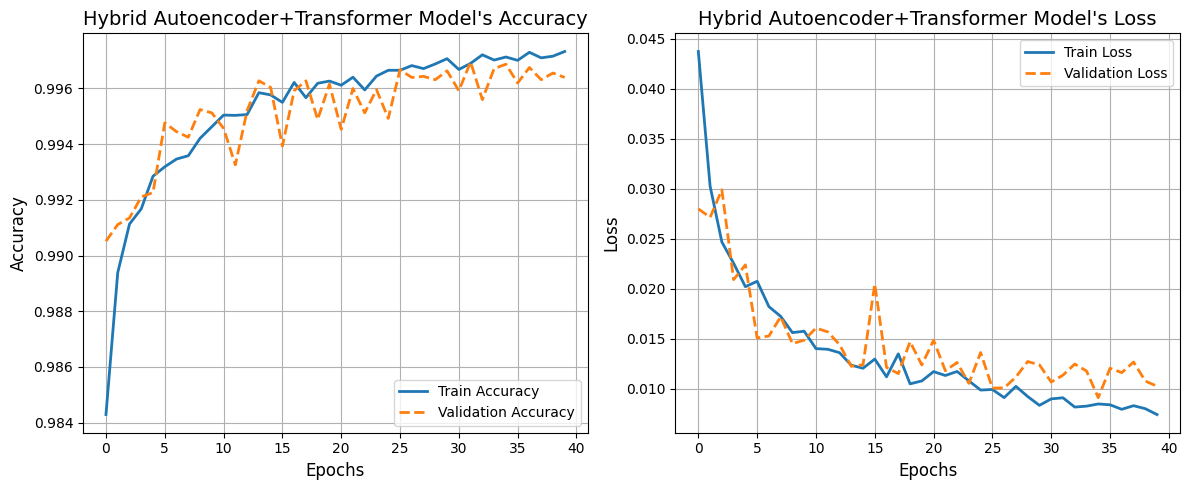

In [14]:
# Training History
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", linewidth=2)
plt.title("Hybrid Autoencoder+Transformer Model's Accuracy", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="--", linewidth=2)
plt.title("Hybrid Autoencoder+Transformer Model's Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("visualization/training_accuracy.png")
plt.close()





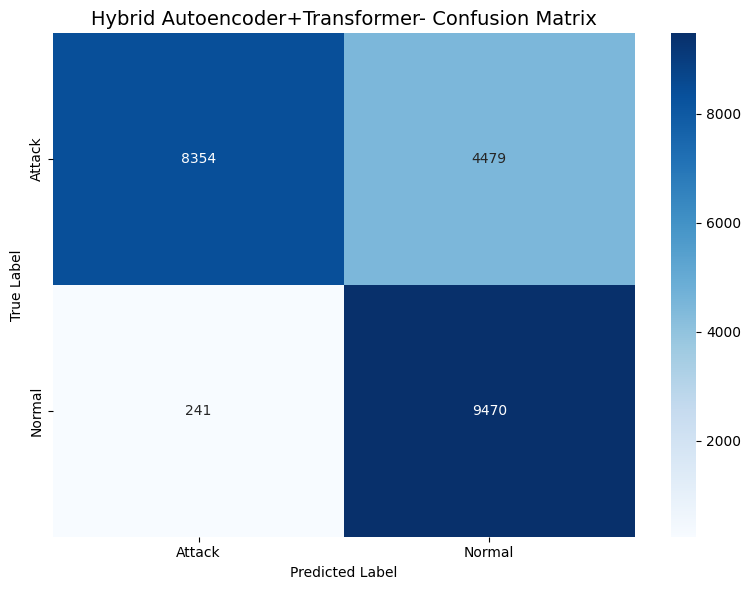

              precision    recall  f1-score   support

      Attack       0.97      0.65      0.78     12833
      Normal       0.68      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.83      0.81      0.79     22544
weighted avg       0.85      0.79      0.79     22544



In [12]:
# Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Hybrid Autoencoder+Transformer- Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("visualization/confusion_matrix.png")
plt.show()
plt.close()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

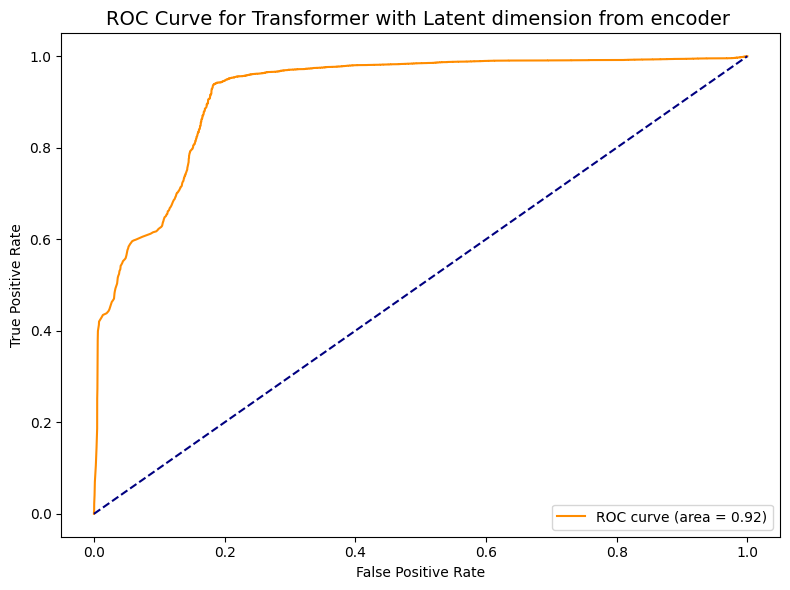

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.title("ROC Curve Transformer+Autoencorder", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("visualization/roc_curve.png")
plt.show()
plt.close()


## Step 6: SHAP Analysis

In [10]:
# # SHAP Analysis
# explainer = shap.Explainer(combined_model, x_train)
# shap_values = explainer(X_test)

# # SHAP Summary Plot
# shap.summary_plot(shap_values, X_test, feature_names=train.columns[:-1])
# plt.savefig("visualization/shap_summary_plot.png")
# plt.close()

# # SHAP Decision Plot
# shap.decision_plot(explainer.expected_value[0], shap_values.values, feature_names=train.columns[:-1])
# plt.savefig("visualization/shap_decision_plot.png")
# plt.close()

# # SHAP Force Plot (Single Instance)
# shap.force_plot(explainer.expected_value[0], shap_values.values[0], X_test[0], feature_names=train.columns[:-1], matplotlib=True)
# plt.savefig("visualization/shap_force_plot.png")
# plt.close()

107/107 [==============================] - 1s 10ms/step


PermutationExplainer explainer:   1%|          | 1/100 [00:00<?, ?it/s]

75/75 [==============================] - 1s 9ms/step


PermutationExplainer explainer:   3%|▎         | 3/100 [00:28<08:29,  5.25s/it]

75/75 [==============================] - 1s 9ms/step


PermutationExplainer explainer:   4%|▍         | 4/100 [00:38<11:28,  7.17s/it]

73/73 [==============================] - 1s 10ms/step


PermutationExplainer explainer:   5%|▌         | 5/100 [00:48<13:00,  8.22s/it]

87/87 [==============================] - 1s 9ms/step


PermutationExplainer explainer:   6%|▌         | 6/100 [01:01<15:29,  9.88s/it]

68/68 [==============================] - 1s 9ms/step


PermutationExplainer explainer:   7%|▋         | 7/100 [01:09<14:40,  9.46s/it]

74/74 [==============================] - 1s 9ms/step


PermutationExplainer explainer:   8%|▊         | 8/100 [01:19<14:28,  9.44s/it]

78/78 [==============================] - 1s 9ms/step


PermutationExplainer explainer:   9%|▉         | 9/100 [01:28<14:23,  9.49s/it]

71/71 [==============================] - 1s 8ms/step


PermutationExplainer explainer:  10%|█         | 10/100 [01:37<13:54,  9.27s/it]

72/72 [==============================] - 1s 9ms/step


PermutationExplainer explainer:  11%|█         | 11/100 [01:47<13:54,  9.37s/it]

63/63 [==============================] - 1s 8ms/step


PermutationExplainer explainer:  12%|█▏        | 12/100 [01:55<13:22,  9.12s/it]

75/75 [==============================] - 1s 8ms/step


PermutationExplainer explainer:  13%|█▎        | 13/100 [02:03<12:39,  8.73s/it]

76/76 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  14%|█▍        | 14/100 [02:11<12:09,  8.49s/it]

74/74 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  15%|█▌        | 15/100 [02:18<11:32,  8.15s/it]

77/77 [==============================] - 1s 6ms/step


PermutationExplainer explainer:  16%|█▌        | 16/100 [02:27<11:35,  8.27s/it]

68/68 [==============================] - 0s 7ms/step


PermutationExplainer explainer:  17%|█▋        | 17/100 [02:33<10:40,  7.72s/it]

63/63 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [02:39<09:48,  7.18s/it]

68/68 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [02:46<09:22,  6.94s/it]

67/67 [==============================] - 0s 7ms/step


PermutationExplainer explainer:  20%|██        | 20/100 [02:51<08:49,  6.62s/it]

77/77 [==============================] - 1s 6ms/step


PermutationExplainer explainer:  21%|██        | 21/100 [02:59<08:54,  6.77s/it]

78/78 [==============================] - 1s 6ms/step


PermutationExplainer explainer:  22%|██▏       | 22/100 [03:06<08:57,  6.90s/it]

64/64 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [03:11<08:25,  6.56s/it]

65/65 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [03:17<07:59,  6.31s/it]

71/71 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  25%|██▌       | 25/100 [03:24<08:01,  6.43s/it]

75/75 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  26%|██▌       | 26/100 [03:31<08:14,  6.69s/it]

76/76 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  27%|██▋       | 27/100 [03:38<08:15,  6.79s/it]

68/68 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  28%|██▊       | 28/100 [03:45<08:06,  6.75s/it]

64/64 [==============================] - 0s 7ms/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [03:51<07:40,  6.49s/it]

65/65 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  30%|███       | 30/100 [03:57<07:34,  6.49s/it]

72/72 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  31%|███       | 31/100 [04:04<07:23,  6.43s/it]

79/79 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  32%|███▏      | 32/100 [04:12<07:57,  7.03s/it]

71/71 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  33%|███▎      | 33/100 [04:19<07:48,  6.99s/it]

70/70 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  34%|███▍      | 34/100 [04:26<07:43,  7.02s/it]

72/72 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [04:34<07:48,  7.21s/it]

83/83 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [04:42<08:02,  7.54s/it]

88/88 [==============================] - 1s 7ms/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [04:52<08:41,  8.28s/it]

63/63 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  38%|███▊      | 38/100 [04:58<07:55,  7.68s/it]

78/78 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  39%|███▉      | 39/100 [05:06<07:46,  7.65s/it]

68/68 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  40%|████      | 40/100 [05:11<07:03,  7.05s/it]

73/73 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  41%|████      | 41/100 [05:17<06:27,  6.58s/it]

66/66 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  42%|████▏     | 42/100 [05:22<05:54,  6.11s/it]

75/75 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  43%|████▎     | 43/100 [05:27<05:28,  5.77s/it]

77/77 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [05:33<05:22,  5.75s/it]

66/66 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  45%|████▌     | 45/100 [05:37<04:56,  5.39s/it]

78/78 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [05:43<04:51,  5.40s/it]

65/65 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [05:47<04:32,  5.13s/it]

63/63 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  48%|████▊     | 48/100 [05:52<04:19,  4.99s/it]

77/77 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  49%|████▉     | 49/100 [05:57<04:25,  5.21s/it]

70/70 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  50%|█████     | 50/100 [06:03<04:25,  5.31s/it]

64/64 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  51%|█████     | 51/100 [06:08<04:09,  5.10s/it]

75/75 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [06:13<04:08,  5.17s/it]

67/67 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [06:18<03:57,  5.05s/it]

79/79 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [06:23<03:58,  5.18s/it]

79/79 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [06:29<03:58,  5.29s/it]

77/77 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [06:34<03:56,  5.37s/it]

69/69 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [06:39<03:44,  5.21s/it]

75/75 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [06:45<03:41,  5.27s/it]

69/69 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [06:49<03:30,  5.14s/it]

74/74 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  60%|██████    | 60/100 [06:55<03:29,  5.25s/it]

60/60 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  61%|██████    | 61/100 [06:59<03:15,  5.02s/it]

69/69 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [07:04<03:07,  4.93s/it]

73/73 [==============================] - 0s 3ms/step


PermutationExplainer explainer:  63%|██████▎   | 63/100 [13:03<1:08:30, 111.10s/it]

66/66 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [13:08<47:30, 79.18s/it]   

64/64 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  65%|██████▌   | 65/100 [13:13<33:12, 56.91s/it]

80/80 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [13:19<23:39, 41.75s/it]

64/64 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [13:23<16:48, 30.55s/it]

84/84 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [13:30<12:27, 23.36s/it]

78/78 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [13:36<09:19, 18.05s/it]

68/68 [==============================] - 0s 4ms/step


PermutationExplainer explainer:  70%|███████   | 70/100 [13:40<07:01, 14.04s/it]

63/63 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  71%|███████   | 71/100 [13:45<05:23, 11.15s/it]

80/80 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [13:50<04:26,  9.51s/it]

71/71 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [13:56<03:43,  8.27s/it]

69/69 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [14:01<03:10,  7.33s/it]

75/75 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [14:06<02:48,  6.72s/it]

78/78 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [14:12<02:33,  6.40s/it]

70/70 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [14:17<02:17,  5.96s/it]

70/70 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [14:22<02:05,  5.69s/it]

73/73 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [14:27<01:58,  5.63s/it]

70/70 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  80%|████████  | 80/100 [14:32<01:49,  5.46s/it]

67/67 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  81%|████████  | 81/100 [14:37<01:40,  5.29s/it]

83/83 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [14:43<01:39,  5.50s/it]

75/75 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [14:49<01:35,  5.63s/it]

71/71 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [14:54<01:28,  5.52s/it]

68/68 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [15:00<01:21,  5.41s/it]

67/67 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [15:04<01:12,  5.17s/it]

73/73 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [15:10<01:08,  5.24s/it]

77/77 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [15:16<01:05,  5.43s/it]

85/85 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [15:22<01:04,  5.87s/it]

60/60 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [15:27<00:54,  5.46s/it]

69/69 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  91%|█████████ | 91/100 [15:32<00:47,  5.29s/it]

71/71 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [15:38<00:43,  5.45s/it]

59/59 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [15:42<00:36,  5.26s/it]

75/75 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  94%|█████████▍| 94/100 [15:48<00:32,  5.35s/it]

71/71 [==============================] - 0s 6ms/step


PermutationExplainer explainer:  95%|█████████▌| 95/100 [15:54<00:27,  5.50s/it]

66/66 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  96%|█████████▌| 96/100 [15:59<00:21,  5.43s/it]

65/65 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  97%|█████████▋| 97/100 [16:04<00:15,  5.26s/it]

66/66 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [16:10<00:10,  5.38s/it]

72/72 [==============================] - 0s 5ms/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [16:15<00:05,  5.29s/it]

69/69 [==============================] - 0s 5ms/step


PermutationExplainer explainer: 100%|██████████| 100/100 [16:20<00:00,  5.23s/it]

78/78 [==============================] - 0s 5ms/step


PermutationExplainer explainer: 101it [16:26,  9.86s/it]                         


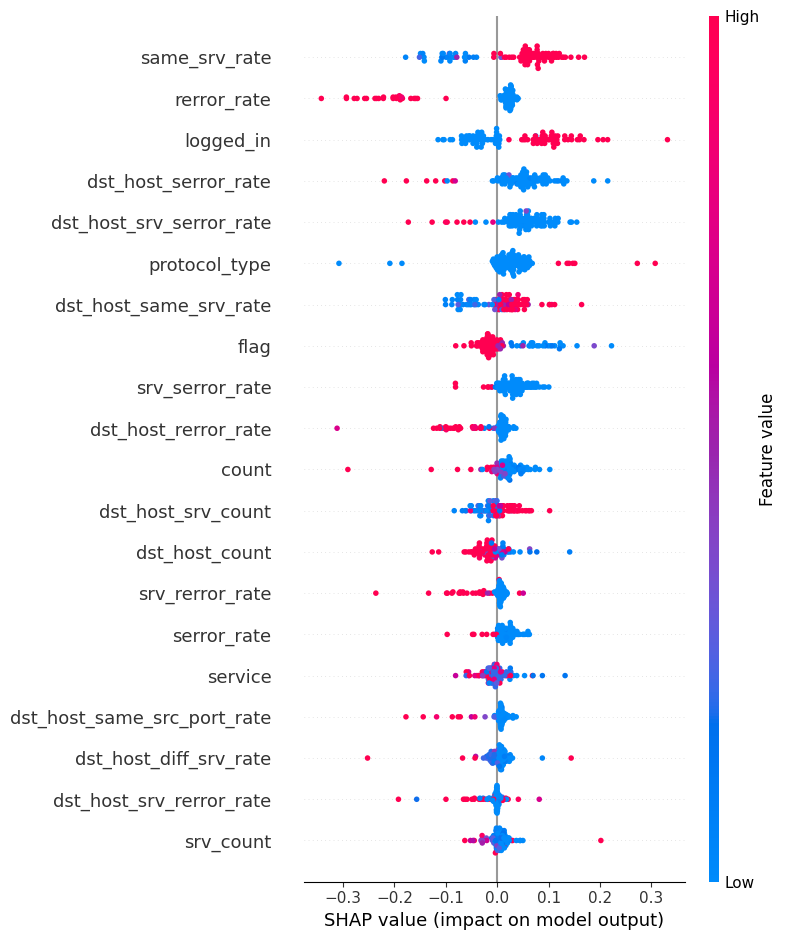

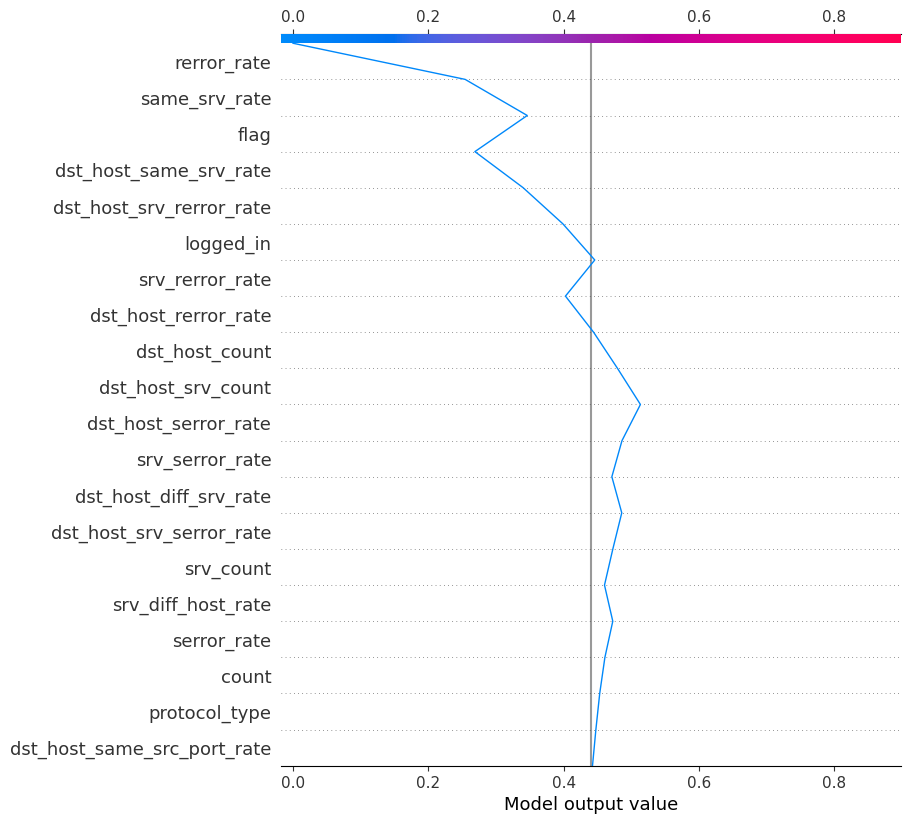

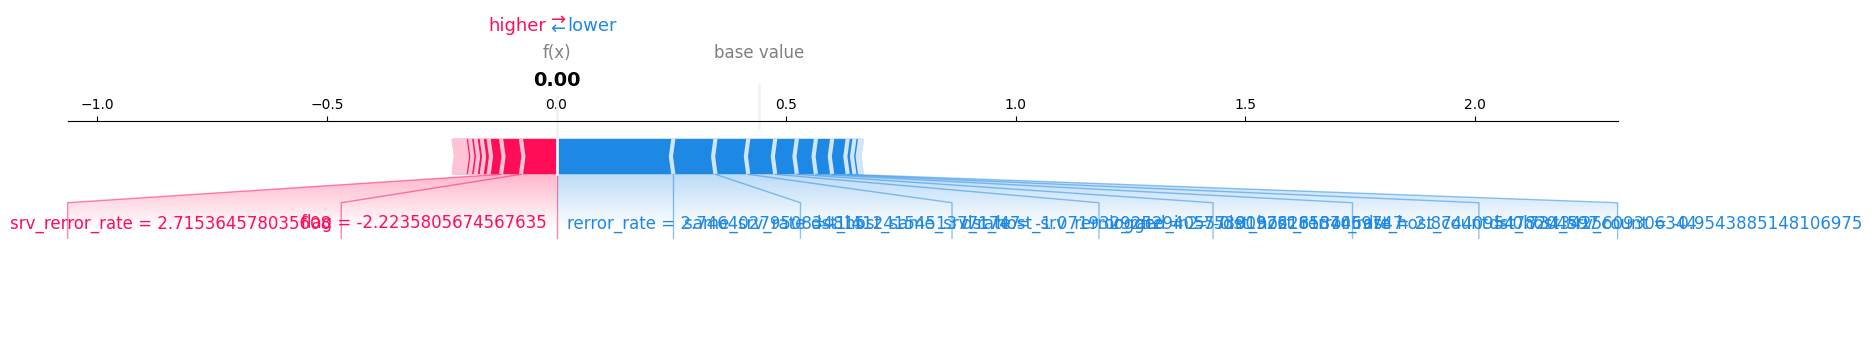

In [11]:
# SHAP Analysis with Partial Data
import shap

# Select a subset of the data for SHAP analysis
subset_size = 100  # Adjust the number of samples as needed
X_test_subset = X_test[:subset_size]
x_train_subset = x_train[:subset_size]

# Initialize the SHAP explainer using the subset of training data
explainer = shap.Explainer(combined_model.predict, x_train_subset)

# Generate SHAP values for the test subset
shap_values = explainer(X_test_subset)

# Define feature names explicitly as a list
feature_names = list(train.columns[:-1])  # Convert to list for SHAP compatibility

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)
plt.savefig("visualization/shap_summary_plot.png")
plt.close()

# SHAP Decision Plot
shap.decision_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    feature_names=feature_names
)
plt.savefig("visualization/shap_decision_plot.png")
plt.close()

# SHAP Force Plot (Single Instance)
shap.force_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    X_test_subset[0], 
    feature_names=feature_names, 
    matplotlib=True
)
shap.save_html(
    "visualization/shap_force_plot.html", 
    shap.force_plot(
        shap_values.base_values[0], 
        shap_values.values[0], 
        X_test_subset[0], 
        feature_names=feature_names
    )
)
